In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
from datetime import datetime
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

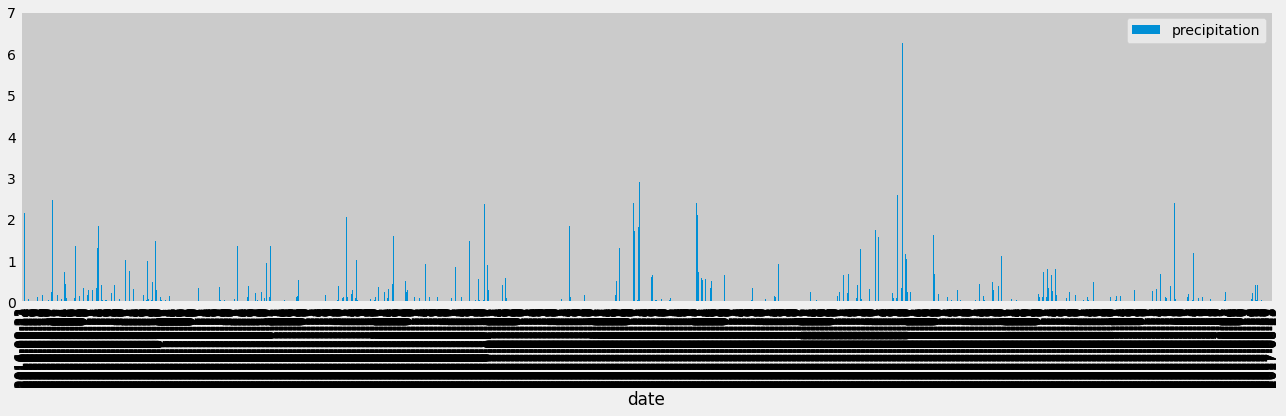

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_day_query = session.query(measurement.date).order_by(measurement.date.desc()).first()
last_day = dt.date(2017, 8, 23)
year_ago = last_day - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
date_precip = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_ago).\
    filter(measurement.date <= last_day).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(date_precip, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar(figsize=(20,5))
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
#session.query(station.station).count()
total_stations = session.query(func.count(distinct(station.station))).scalar()
print(f"Total Stations: {total_stations}")

Total Stations: 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.id)).group_by(measurement.station).\
order_by(func.count(measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = 'USC00519281'
lowest_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == station_id).scalar()
highest_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == station_id).scalar()
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == station_id).scalar()
print(f"Low: {lowest_temp}, High: {highest_temp}, Avg: {avg_temp}")

Low: 54.0, High: 85.0, Avg: 71.66378066378067


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temps = session.query(measurement.station, measurement.tobs).\
    filter(measurement.date >= year_ago).\
    filter(measurement.date <= last_day).\
    order_by(measurement.station).all()

temp_df = pd.DataFrame(station_temps, columns=['station', 'temp'])
counts = temp_df.groupby('station').count()['temp']
counts


station
USC00513117    343
USC00514830    305
USC00516128    349
USC00517948    183
USC00519281    352
USC00519397    361
USC00519523    337
Name: temp, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001604BB6D108>]],
      dtype=object)

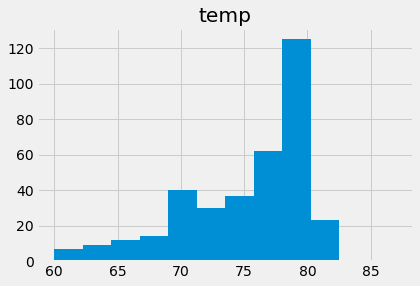

In [20]:
most_active = "USC00519397"
new_df = temp_df.loc[temp_df['station'] == most_active]
new_df

new_df.hist(column='temp', bins=12)

### BonusTemperature Analysis I

In [21]:
# Find the Average Temperature in June across all years
"""
I really tried getting the average temperatures through SQLalchemy but i could not figure out how to isolate the stations.
It kept returning the stations as a list of tuples and i could not get them isolated to find the average temp of each station.

"""

# station_list = session.query(measurement.station).distinct()

# station_dict_jun = {}

# for station in station_list:
#     station_dict_jun[station] = session.query(measurement.tobs).\
#     filter(measurement.station == station).\
#     filter(measurement.date.like('%-06-%')).all()

# avg_temp_jun = []

# for key in station_dict_jun:
#         avg_temp = np.mean(station_dict_jun[key])
#         avg_temp_jun.append(avg_temp)

# avg_temp_jun

'\nI really tried getting the average temperatures through SQLalchemy but i could not figure out how to isolate the stations.\nIt kept returning the stations as a list of tuples and i could not get them isolated to find the average temp of each station.\n\n'

In [22]:
# station_dict_dec = {}

# for station in station_list:
#     station_dict_dec[station] = session.query(measurement.tobs).\
#     filter(measurement.station == station).\
#     filter(measurement.date.like('%-12-%')).all()

#avg_temp_dec = []


# for item in station_dict_dec.items():
#         avg_temp = np.mean(item)
#         avg_temp_dec.append(avg_temp)
        
#avg_temp_dec

In [23]:
file1 = "Resources/hawaii_measurements.csv"
file2 = "Resources/hawaii_stations.csv"
measurement_df = pd.read_csv(file1)
station_df = pd.read_csv(file2)
measurement_df

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71
19546,USC00516128,2017-08-20,NaN,78
19547,USC00516128,2017-08-21,0.56,76
19548,USC00516128,2017-08-22,0.50,76


In [24]:
jun_df = measurement_df[measurement_df['date'].str.contains('-06-')]
avg_temp_jun = jun_df.groupby('station').mean()['tobs']
avg_temp_jun

station
USC00511918    74.139394
USC00513117    74.050847
USC00514830    76.005376
USC00516128    71.937220
USC00517948    76.655405
USC00518838    73.394737
USC00519281    73.271186
USC00519397    77.559322
USC00519523    76.668103
Name: tobs, dtype: float64

In [25]:
dec_df = measurement_df[measurement_df['date'].str.contains('-12-')]
avg_temp_dec = dec_df.groupby('station').mean()['tobs']
avg_temp_dec

station
USC00511918    69.684211
USC00513117    71.069444
USC00514830    73.224719
USC00516128    69.291262
USC00517948    71.834862
USC00518838    72.421053
USC00519281    69.903226
USC00519397    71.109524
USC00519523    72.433333
Name: tobs, dtype: float64

In [26]:
population1 = avg_temp_jun
population2 = avg_temp_dec

stats.ttest_ind(population1, population2, equal_var=False)

Ttest_indResult(statistic=4.615865424404701, pvalue=0.0003657335214469917)

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-06-01', '2017-06-07'))

[(74.0, 77.84444444444445, 81.0)]


In [50]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-06-01', '2017-06-07')
trip_temps

[(74.0, 77.84444444444445, 81.0)]

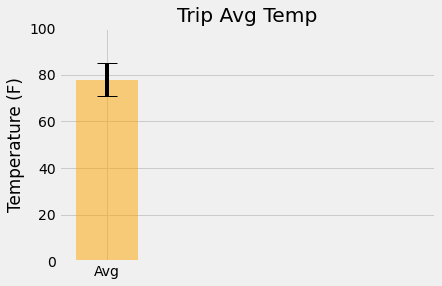

In [51]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = "Avg"
y = 77.84
error = 7

plt.bar(x, y, yerr=error, width=1, capsize=10, alpha=0.5, color='orange')
plt.ylim(0, 100)
plt.ylabel('Temperature (F)')
plt.title('Trip Avg Temp')
plt.hlines(range(0, 100, 20), xmin=5, xmax=5, linestyle=':', alpha=0.5)
plt.show()

In [52]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_df = measurement_df[(measurement_df['date'] >= '2017-06-01') & (measurement_df['date'] <= '2017-06-07')]
total_rain = trip_df.groupby('station').sum()['prcp']
total_rain

rain_df = pd.DataFrame(total_rain)
rain_df

merged_df = rain_df.merge(station_df, how='inner', on='station')
merged_df = merged_df.sort_values('prcp', ascending=False)
merged_df


,station,prcp,name,latitude,longitude,elevation
2,USC00516128,0.85,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
0,USC00513117,0.48,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,USC00514830,0.38,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519281,0.35,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
6,USC00519523,0.15,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.02,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
3,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [53]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [66]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

trip_dates = []
normals = []


trip_start = dt.date(2017, 6, 1)
trip_start_input = trip_start.strftime('%Y-%m-%d')[-5:]
trip_length = 7

date_list = [trip_start + dt.timedelta(days=x) for x in range(trip_length)]
date_list

for date in date_list:
    input_date = date.strftime('%Y-%m-%d')[-5:]
    trip_dates.append(input_date)
    
trip_dates

for day in trip_dates:
    normals.append(daily_normals(day))
    
normals

[[(64.0, 74.6140350877193, 81.0)],
 [(65.0, 74.4, 81.0)],
 [(65.0, 74.03448275862068, 80.0)],
 [(65.0, 73.81818181818181, 81.0)],
 [(68.0, 74.85454545454546, 81.0)],
 [(70.0, 75.17543859649123, 80.0)],
 [(68.0, 75.07142857142857, 81.0)]]

In [91]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
flat_list = [x for sublist in normals for x in sublist]
flat_list
# trip_df = pd.DataFrame({'date': date_list, 'tmin/tavg/tmax': normals})
# trip_df

trip_df = pd.DataFrame(flat_list, columns=['tmin', 'tavg', 'tmax'])
trip_df.index = date_list
trip_df

,tmin,tavg,tmax
2017-06-01,64.0,74.614035,81.0
2017-06-02,65.0,74.400000,81.0
2017-06-03,65.0,74.034483,80.0
2017-06-04,65.0,73.818182,81.0
2017-06-05,68.0,74.854545,81.0
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0


Text(0, 0.5, 'Temperature (F)')

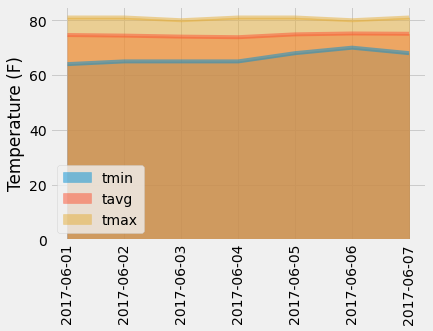

In [95]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False, rot=90)
plt.ylabel('Temperature (F)')